# План решения
### Решение кейса построено по следующему плану: 
1. импорт библиотек
2. загрузка и первичный анализ данных
3. предобработка данных
4. разведочный анализ
5. разделение данных на обучающую и тестовую выборки

    > Так как целевых переменных у нас две, то для получения прогноза по каждой из них будет осуществляться обучение отдельной модели  

6. Для получения прогноза применим три различных подхода:
    1. линейная регрессия
    2. случайный лес
    3. градиентный бустинг
7. Сравенения результатов полученных разными подходами
8. Выбор наилучшей модели
9. Экспорт моделей градиентного бустинга для использования в веб-приложении .NET (C#)    


# Импорт необходимых библиотек
Используемые библиотеки:
- pandas,
- matplotlib, 
- seaborn, 
- scikit-learn.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Настройка отображения графиков
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Загрузка и первичный анализ данных
Загружаем данные из ebw_data.csv выводим первые 5 строк, статистические показатели набора данных и делаем проверку на пропущенные значения.

In [28]:
data = pd.read_csv('ebw_data.csv')

print("Первые 5 строк данных")
print(data.head())
print()

print("Статистические показатели набора данных")
print(data.describe())
print()

print("Количество пропущенных значений")
print(data.isnull().sum())
print()

Первые 5 строк данных
   IW   IF   VW  FP  Depth  Width
0  47  139  4.5  80   1.60   2.54
1  47  139  4.5  80   1.62   2.50
2  47  139  4.5  80   1.68   2.60
3  47  139  4.5  80   1.58   2.52
4  45  140  4.5  80   1.76   2.48

Статистические показатели набора данных
              IW          IF         VW          FP      Depth      Width
count  72.000000   72.000000  72.000000   72.000000  72.000000  72.000000
mean   45.666667  141.333333   8.638889   78.333333   1.195556   1.970417
std     1.678363    5.145763   2.061078   21.493530   0.225081   0.279040
min    43.000000  131.000000   4.500000   50.000000   0.800000   1.680000
25%    44.000000  139.000000   8.000000   60.000000   1.080000   1.760000
50%    45.500000  141.000000   9.000000   80.000000   1.200000   1.840000
75%    47.000000  146.000000  10.000000   80.000000   1.290000   2.050000
max    49.000000  150.000000  12.000000  125.000000   1.760000   2.600000

Количество пропущенных значений
IW       0
IF       0
VW       0
F

# Предобработка данных
Обычно предобработка данных включает в себя:
- обработку пропущенных значений, 
- кодирование категориальных переменных (если есть)
- нормализацию числовых признаков.

### Обработка пропущенных значений
В нашем случае пропусков данных нет, поэтому этот шаг пропускаем. Если бы пропуски были, то можно было бы заполнить пропуски средними значениями по столбцу

### Кодирование категориальных переменных
В нашем случае нет категориальных переменных, поэтому этот шаг пропускаем. В случае, если бы такие переменные были бы в датасете, то можно было бы перевести их в числовой формат (именно он может быть обработан алгоритмом машинного обучения) используя например порядковое кодирование (каждому уникальному значению категориальной переменной соответствует порядкоый номер) или быстрое кодирование (каждому значению категориальной переменной соответствует столбец в который соответственно записывается 0 или 1 в зависимости от присутствия этого значения в строке набора данных)

### Нормализация числовых признаков
В целом нормализация - это устранение различий в масштабе значений переменных, что в свою очередь дает ряд преимуществ: улучшение производительнисти алгоритмов, уменьшение влияния выбросов, улучшение интерпретации результатов. В нашем случае значения переменных отличаются на один и более порядков, поэтому имеет смысл провести нормализацию.

In [29]:
# Выделение признаков и целевых переменных
features = data[['IW', 'IF', 'VW', 'FP']]
target_depth = data['Depth']
target_width = data['Width']

# Нормализация признаков
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Преобразование обратно в DataFrame
features_scaled = pd.DataFrame(features_scaled, columns=features.columns)

# Просмотр первых строк нормализованных данных
print("Первые 5 строк нормализованных данных")
print(features_scaled.head())

Первые 5 строк нормализованных данных
    IW        IF       VW        FP
0  0.8 -0.456630 -2.02221  0.078087
1  0.8 -0.456630 -2.02221  0.078087
2  0.8 -0.456630 -2.02221  0.078087
3  0.8 -0.456630 -2.02221  0.078087
4 -0.4 -0.260931 -2.02221  0.078087


# Разведочный анализ данных
Разведочный анализ позволяет лучше понять данные и оценить их качество, обнаружить аномалии, определить тенденции и закономерности.
Выполните разведочный анализ данных, включая построение графиков распределения признаков и целевых переменных, а также анализ корреляций между признаками.

В нашем случае данные полные, без выбросов и аномалий. Есть **сильная** корреляция между значениями ширины шва и скоростью сварки (чем выше скоорость, тем уже шов).

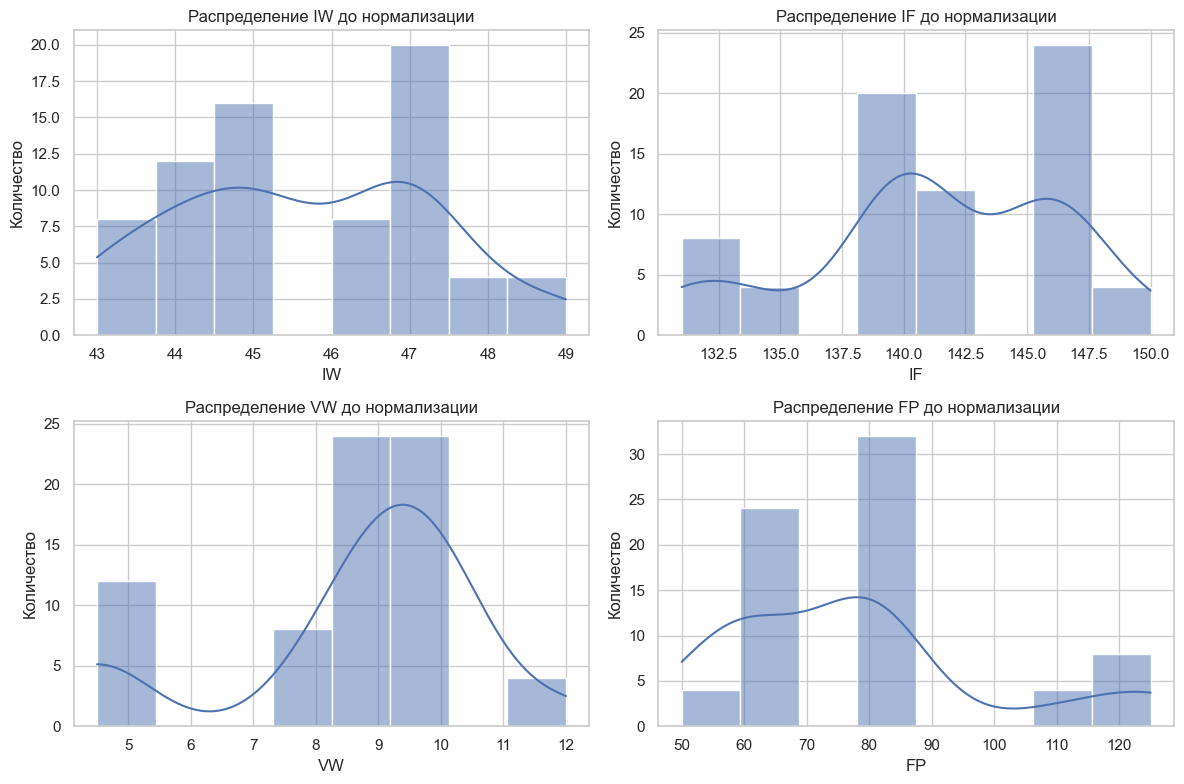

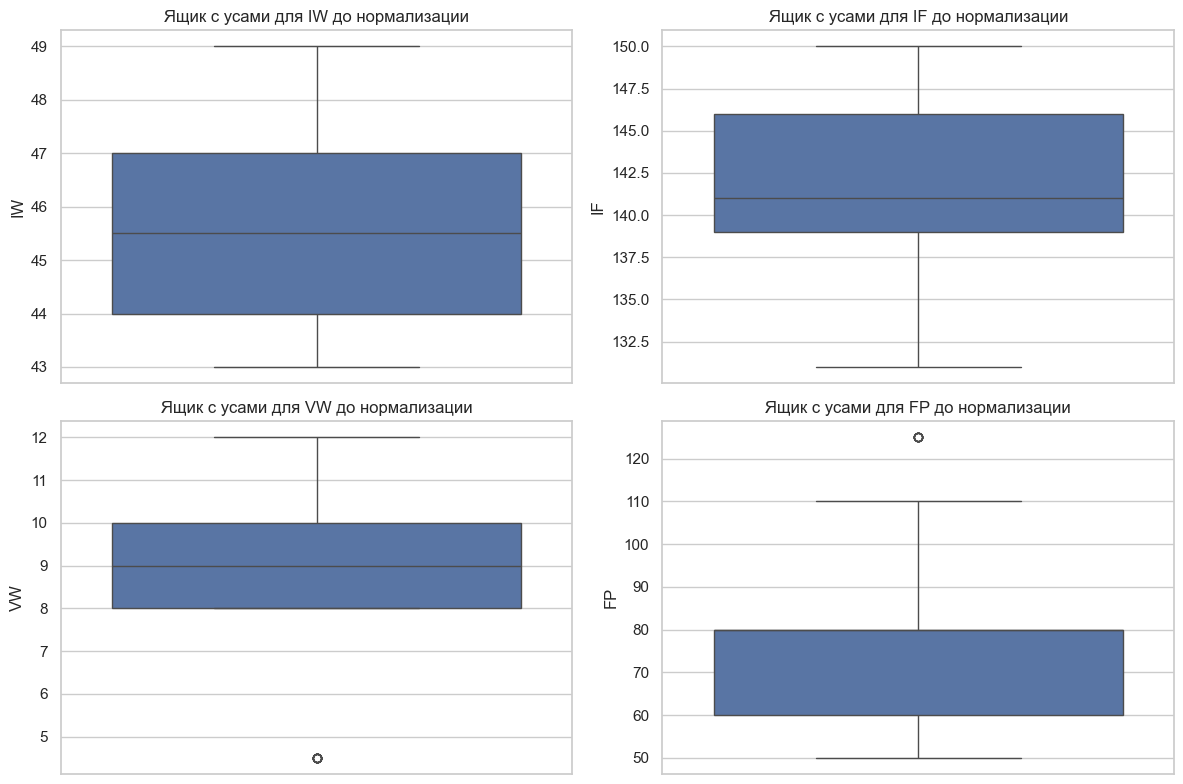

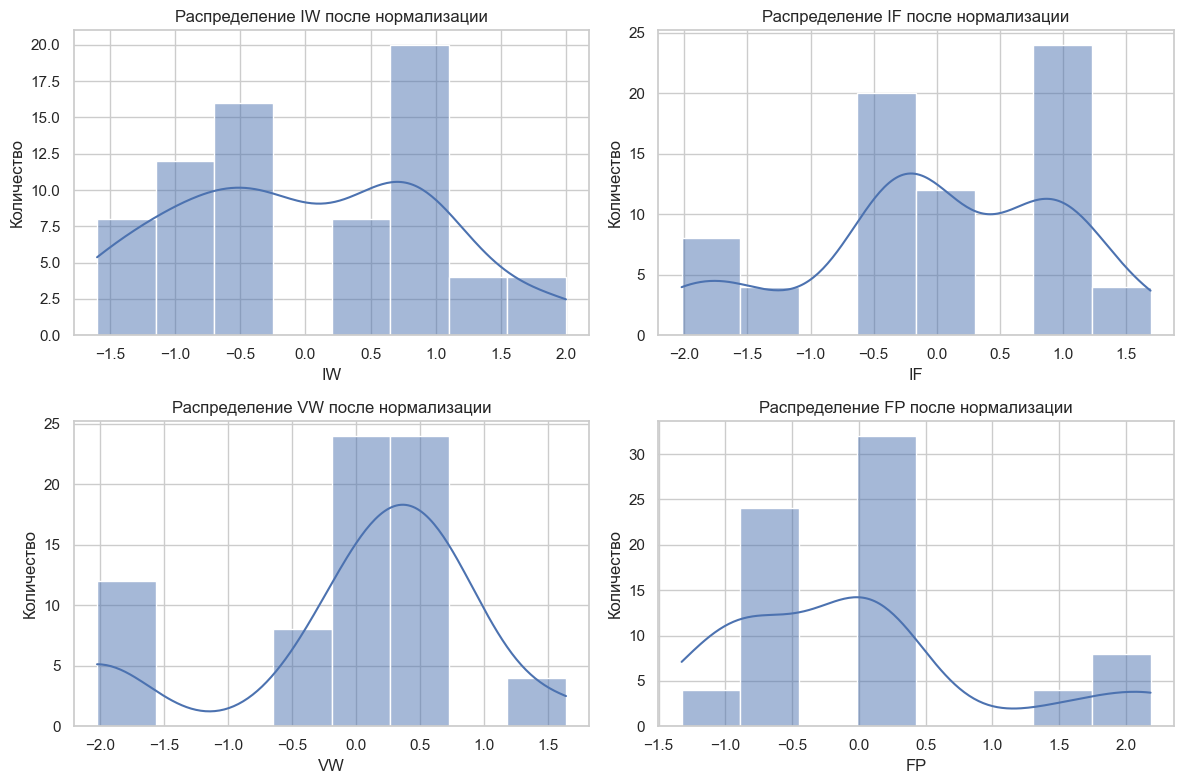

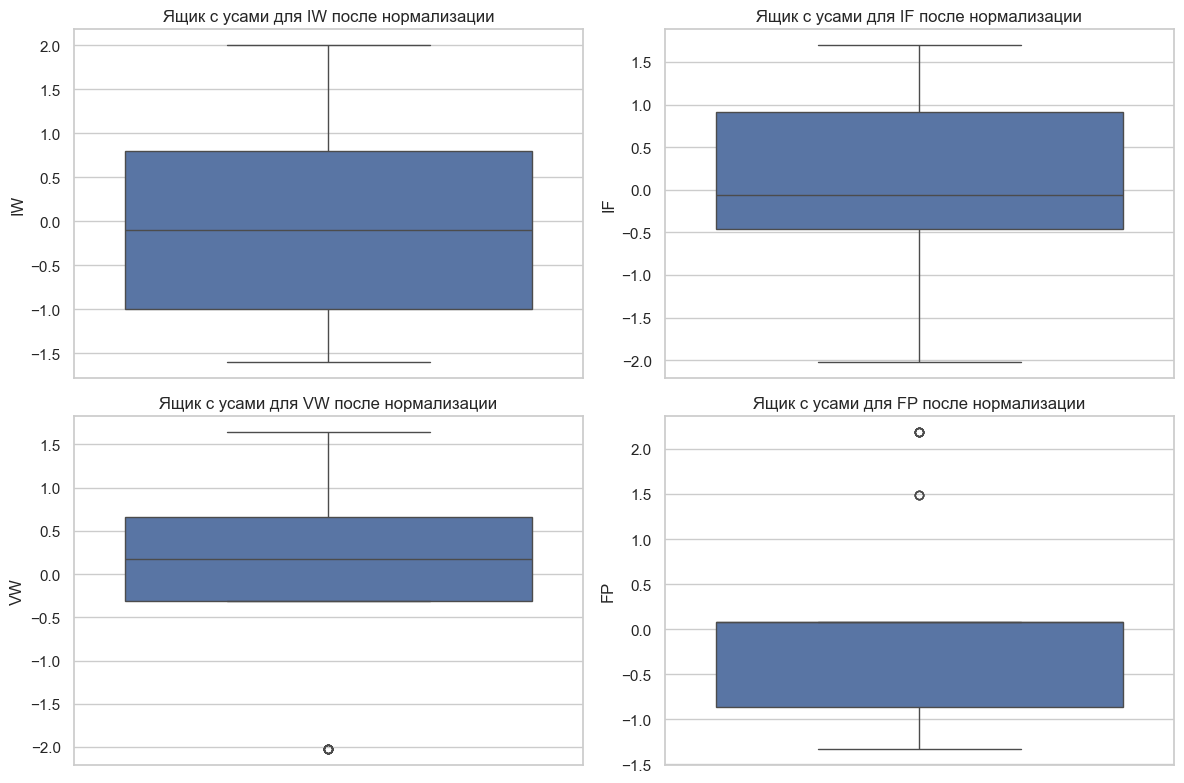

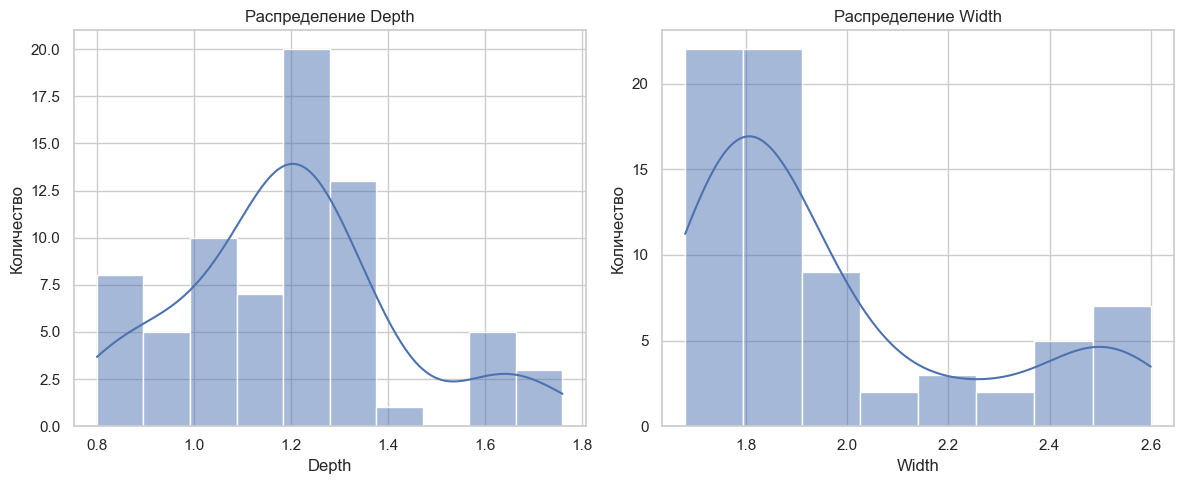

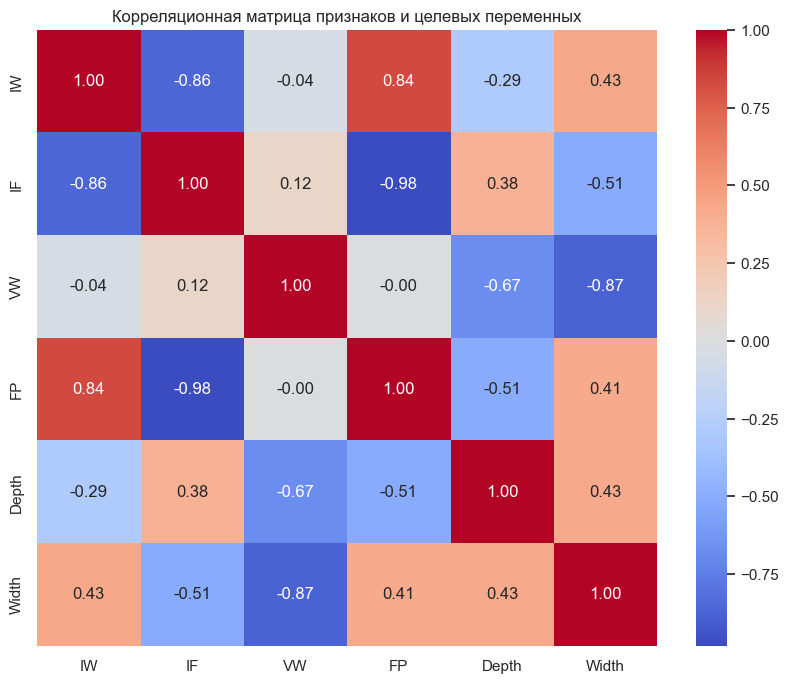

In [30]:
# Разведочный анализ данных

# Построение графиков распределения признаков до нормализации
plt.figure(figsize=(12, 8))
for i, column in enumerate(features.columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[column], kde=True)
    plt.ylabel('Количество')
    plt.title(f'Распределение {column} до нормализации')
plt.tight_layout()
plt.show()

# Построение графиков ящики с усами для признаков до нормализации
plt.figure(figsize=(12, 8))
for i, column in enumerate(features.columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data[column])
    plt.title(f'Ящик с усами для {column} до нормализации')
plt.tight_layout()
plt.show()

# Построение графиков распределения признаков после нормализации
plt.figure(figsize=(12, 8))
for i, column in enumerate(features.columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(features_scaled[column], kde=True)
    plt.ylabel('Количество')
    plt.title(f'Распределение {column} после нормализации')
plt.tight_layout()
plt.show()

# Построение графиков ящики с усами для признаков после нормализации
plt.figure(figsize=(12, 8))
for i, column in enumerate(features.columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(features_scaled[column])
    plt.title(f'Ящик с усами для {column} после нормализации')
plt.tight_layout()
plt.show()

# Построение графиков распределения целевых переменных
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(target_depth, kde=True)
plt.title('Распределение Depth')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
sns.histplot(target_width, kde=True)
plt.title('Распределение Width')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

# Анализ корреляций между признаками и целевыми переменными
correlation_matrix = data.corr()

# Построение тепловой карты корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица признаков и целевых переменных')
plt.show()

# Разделение данных на обучающую и тестовую выборки
Разделяем датасет на обучающую и тестовую выборки с использованием функции train_test_split из библиотеки scikit-learn.

In [31]:
# Разделение данных на обучающую и тестовую выборки

# Разделение данных на обучающую и тестовую выборки для предсказания глубины шва
X_train_depth, X_test_depth, y_train_depth, y_test_depth = train_test_split(features_scaled, target_depth, test_size=0.2, random_state=42)

# Разделение данных на обучающую и тестовую выборки для предсказания ширины шва
X_train_width, X_test_width, y_train_width, y_test_width = train_test_split(features_scaled, target_width, test_size=0.2, random_state=42)

# Проверка размеров полученных выборок
print(f'Размер обучающей выборки для Depth: {X_train_depth.shape}')
print(f'Размер тестовой выборки для Depth: {X_test_depth.shape}')
print(f'Размер обучающей выборки для Width: {X_train_width.shape}')
print(f'Размер тестовой выборки для Width: {X_test_width.shape}')
print(X_train_depth.head())
print(y_train_depth.head())

Размер обучающей выборки для Depth: (57, 4)
Размер тестовой выборки для Depth: (15, 4)
Размер обучающей выборки для Width: (57, 4)
Размер тестовой выборки для Width: (15, 4)
     IW        IF        VW        FP
22  0.8 -0.065233  1.642198  0.078087
56 -1.0  0.913259  0.176434 -0.858956
49 -1.0  0.913259  0.176434 -0.858956
33  1.4 -2.022217  0.665022  2.186433
39  2.0 -1.826519 -0.312153  2.186433
22    1.20
56    1.20
49    1.32
33    0.86
39    0.80
Name: Depth, dtype: float64


# Линейная регрессия
Обучение моделей линейной регрессии для определения глубины и ширины шва. Проверка на тестовой выборке и оценка результатов

In [32]:
# Целевая переменная - глубина шва
# Обучение 
linear_regressor_depth = LinearRegression()
linear_regressor_depth.fit(X_train_depth, y_train_depth)

# Предсказание на тестовой выборке
y_pred_depth = linear_regressor_depth.predict(X_test_depth)

# Оценка качества
mse_depth = mean_squared_error(y_test_depth, y_pred_depth)
r2_depth = r2_score(y_test_depth, y_pred_depth)
print("Линейная регрессия")
print("Среднеквадратичная ошибка (MSE) и коэффициент детерминации (R2)")
print(f'Глубина шва: MSE = {mse_depth}, R2 = {r2_depth}')

# Целевая переменная - ширина шва
# Обучение
linear_regressor_width = LinearRegression()
linear_regressor_width.fit(X_train_width, y_train_width)

# Предсказание на тестовой выборке
y_pred_width = linear_regressor_width.predict(X_test_width)

# Оценка качества
mse_width = mean_squared_error(y_test_width, y_pred_width)
r2_width = r2_score(y_test_width, y_pred_width)

print(f'Ширина шва: MSE = {mse_width}, R2 = {r2_width}')

Линейная регрессия
Среднеквадратичная ошибка (MSE) и коэффициент детерминации (R2)
Глубина шва: MSE = 0.02233227825116981, R2 = 0.6154439932565047
Ширина шва: MSE = 0.002293102104561903, R2 = 0.9771234759184153


# Регрессия с использованием случайного леса
Обучение моделей регрессии с использованием случайного леса для определения глубины и ширины шва. Проверка на тестовой выборке и оценка результатов

In [33]:
# Целевая переменная - глубина шва
# Обучение
rf_regressor_depth = RandomForestRegressor(random_state=42)
rf_regressor_depth.fit(X_train_depth, y_train_depth)

# Предсказание на тестовой выборке
y_pred_depth_rf = rf_regressor_depth.predict(X_test_depth)

# Оценка качества 
mse_depth_rf = mean_squared_error(y_test_depth, y_pred_depth_rf)
r2_depth_rf = r2_score(y_test_depth, y_pred_depth_rf)

print("Случайный лес")
print("Среднеквадратичная ошибка (MSE) и коэффициент детерминации (R2)")
print(f'Глубина шва: MSE = {mse_depth_rf}, R2 = {r2_depth_rf}')

# Целевая переменная - ширина шва
# Обучение
rf_regressor_width = RandomForestRegressor(random_state=42)
rf_regressor_width.fit(X_train_width, y_train_width)

# Предсказание на тестовой выборке
y_pred_width_rf = rf_regressor_width.predict(X_test_width)

# Оценка качества 
mse_width_rf = mean_squared_error(y_test_width, y_pred_width_rf)
r2_width_rf = r2_score(y_test_width, y_pred_width_rf)

print(f'Ширина шва: MSE = {mse_width_rf}, R2 = {r2_width_rf}')

Случайный лес
Среднеквадратичная ошибка (MSE) и коэффициент детерминации (R2)
Глубина шва: MSE = 0.007827756778291919, R2 = 0.8652080699262473
Ширина шва: MSE = 0.0021298860705076684, R2 = 0.9787517573307931


# Регрессия с использованием градиентного бустинга
Обучение моделей регрессии с использованием градиентного бустинга для определения глубины и ширины шва. Проверка на тестовой выборке и оценка результатов

In [34]:
# Целевая переменная - глубина шва
# Обучение
gb_regressor_depth = GradientBoostingRegressor(random_state=42)
gb_regressor_depth.fit(X_train_depth, y_train_depth)

# Предсказание на тестовой выборке
y_pred_depth_gb = gb_regressor_depth.predict(X_test_depth)

# Оценка качества
mse_depth_gb = mean_squared_error(y_test_depth, y_pred_depth_gb)
r2_depth_gb = r2_score(y_test_depth, y_pred_depth_gb)
print("Градиентный бустинг")
print("Среднеквадратичная ошибка (MSE) и коэффициент детерминации (R2)")
print(f'Глубина шва: MSE = {mse_depth_gb}, R2 = {r2_depth_gb}')

# Целевая переменная - ширина шва
# Обучение
gb_regressor_width = GradientBoostingRegressor(random_state=42)
gb_regressor_width.fit(X_train_width, y_train_width)

# Предсказание на тестовой выборке
y_pred_width_gb = gb_regressor_width.predict(X_test_width)

# Оценка качества
mse_width_gb = mean_squared_error(y_test_width, y_pred_width_gb)
r2_width_gb = r2_score(y_test_width, y_pred_width_gb)

print(f'Ширина шва: MSE = {mse_width_gb}, R2 = {r2_width_gb}')

Градиентный бустинг
Среднеквадратичная ошибка (MSE) и коэффициент детерминации (R2)
Глубина шва: MSE = 0.006922218550946863, R2 = 0.8808012020171552
Ширина шва: MSE = 0.0017438690876888764, R2 = 0.9826027532309699


# Оценка результатов регрессий
Оценка результатов всех трёх видов моделей регрессии по метрикам качества (MSE и R2) и их визуализация.


                Модель  MSE глубина шва  R2 глубина шва  MSE ширина шва  \
0   Линейная регрессия         0.022332        0.615444        0.002293   
1        Случайный лес         0.007828        0.865208        0.002130   
2  Градиентный бустинг         0.006922        0.880801        0.001744   

   R2 ширина шва  
0       0.977123  
1       0.978752  
2       0.982603  


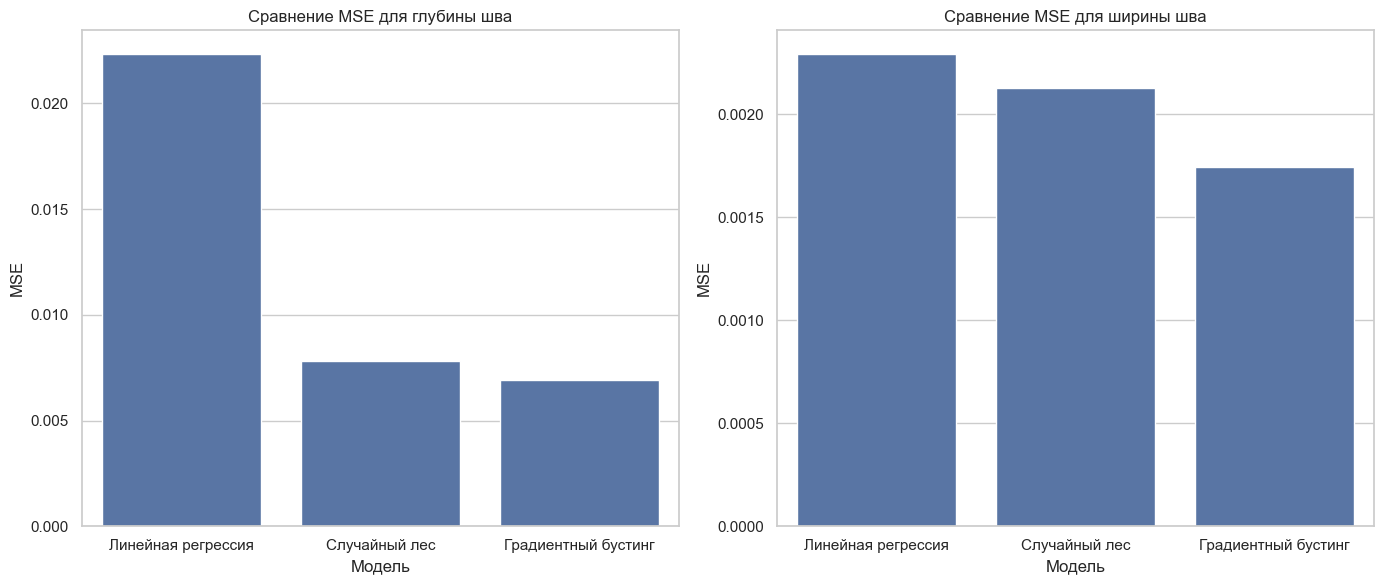

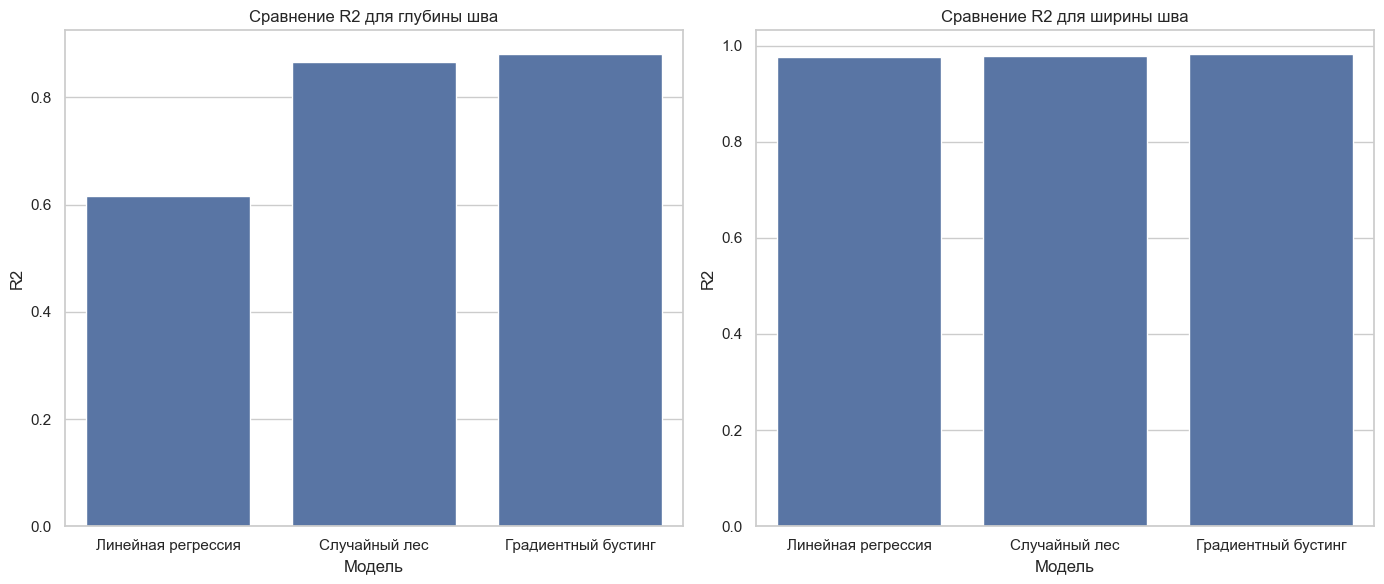

In [35]:

# DataFrame для результатов оценки качества
results = pd.DataFrame({
    'Модель': ['Линейная регрессия', 'Случайный лес', 'Градиентный бустинг'],
    'MSE глубина шва': [mse_depth, mse_depth_rf, mse_depth_gb],
    'R2 глубина шва': [r2_depth, r2_depth_rf, r2_depth_gb],
    'MSE ширина шва': [mse_width, mse_width_rf, mse_width_gb],
    'R2 ширина шва': [r2_width, r2_width_rf, r2_width_gb]
})

# Результаты оценки качества
print(results)

# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Визуализация MSE
sns.barplot(x='Модель', y='MSE глубина шва', data=results, ax=axes[0])
axes[0].set_title('Сравнение MSE для глубины шва')
axes[0].set_ylabel('MSE')

sns.barplot(x='Модель', y='MSE ширина шва', data=results, ax=axes[1])
axes[1].set_title('Сравнение MSE для ширины шва')
axes[1].set_ylabel('MSE')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Визуализация R2
sns.barplot(x='Модель', y='R2 глубина шва', data=results, ax=axes[0])
axes[0].set_title('Сравнение R2 для глубины шва')
axes[0].set_ylabel('R2')

sns.barplot(x='Модель', y='R2 ширина шва', data=results, ax=axes[1])
axes[1].set_title('Сравнение R2 для ширины шва')
axes[1].set_ylabel('R2')

plt.tight_layout()
plt.show()

# Выбор наилучшей модели
Сранвиваем результаты моделей по метрикам MSE и R2 и выбираем лучшую
> R2 - чем больше показатель, тем лучше  
> MSE - чем меньше показатель, тем лучше

In [36]:
# Выбор наилучшей модели

# На основе результатов сравнения моделей, можно сделать вывод о том, какая модель показала наилучшие результаты.


# Определение наилучшей модели для предсказания глубины шва (Depth) по метрике R2
best_model_depth_r2 = results.loc[results['R2 глубина шва'].idxmax()]['Модель']

# Определение наилучшей модели для предсказания глубины шва (Depth) по метрике R2
best_model_depth_mse = results.loc[results['MSE глубина шва'].idxmin()]['Модель']

print(f'Наилучшая модель для предсказания глубины шва по метрике R2: {best_model_depth_r2}')
print(f'Наилучшая модель для предсказания глубины шва по метрике MSE: {best_model_depth_mse}')


# Определение наилучшей модели для предсказания ширины шва (Width) по метрике R2
best_model_width_r2 = results.loc[results['R2 ширина шва'].idxmax()]['Модель']
best_model_width_mse = results.loc[results['MSE ширина шва'].idxmin()]['Модель']


print(f'Наилучшая модель для предсказания ширины шва по метрике R2: {best_model_width_r2}')
print(f'Наилучшая модель для предсказания ширины шва по метрике MSE: {best_model_width_mse}')

Наилучшая модель для предсказания глубины шва по метрике R2: Градиентный бустинг
Наилучшая модель для предсказания глубины шва по метрике MSE: Градиентный бустинг
Наилучшая модель для предсказания ширины шва по метрике R2: Градиентный бустинг
Наилучшая модель для предсказания ширины шва по метрике MSE: Градиентный бустинг


# Экспорт моделей для веб-приложения
Экспорируем модели в формат ONNX (поддерживается в .NET)
> Использовать версию ONNX = 1.16.1, более поздние содержат баг с импортом конвертера

In [37]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# конвертация моделей в формат ONNX
initial_type = [('float_input', FloatTensorType([1, 4]))]
onnx_model_depth = convert_sklearn(gb_regressor_depth, initial_types=initial_type)
onnx_model_width = convert_sklearn(gb_regressor_width, initial_types=initial_type)

# сохранение моделей в файл
with open("model_depth.onnx", "wb") as f:
    f.write(onnx_model_depth.SerializeToString())
with open("model_width.onnx", "wb") as f:
    f.write(onnx_model_width.SerializeToString())